# Long Call Option

### I. Strategy Overview

This is the most basic option strategy composed of a single long call leg.

#### Payoff
Option Payoff or Profit and Loss (P&L) diagrams help us understand where our options strategies win or lose money at expiration based on different stock price points.

<!-- ![](long_call.jpg) -->
<img src='.long_call.jpg'/>

#### Features (optional):
* Long Delta: option value increases as the underlying price goes up
* Short Theta: option value decreases as time decays
* Long volatility: option value increases as the implied volatility hikes

### II. Strategy Setup
* Observe the historical price of selected underlying
* Find avaialble expiration dates for options
* Select an expiration date, option type and stike price for the option strategy
* Select entrance and exit point (simplified by choosing future enter and exit dates)

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting, GetPriceHistory
import pandas as pd
import numpy as np
from datetime import timedelta

####  a. Select underlying by ticker

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


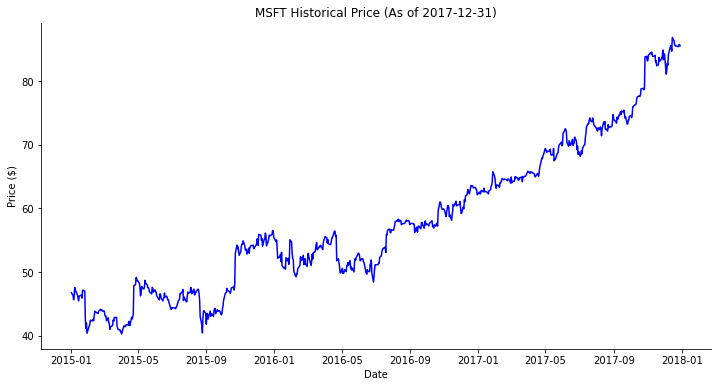

In [2]:
Ticker = 'MSFT'
GetPriceHistory(Ticker).plot_price_history()

#### b. Find expiration dates for testing period

In [3]:
Start_Date = datetime.datetime(2018, 1, 4)
End_Date = datetime.datetime(2018,6, 30)

GetDays(Ticker, Start_Date, End_Date, []).expiration_dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Expiration Date,Day of the Week,Year-Month,Expiration
0,2018-01-19,Friday,2018-01,1
1,2018-02-16,Friday,2018-02,1
2,2018-03-16,Friday,2018-03,1
3,2018-04-20,Friday,2018-04,1
4,2018-05-18,Friday,2018-05,1
5,2018-06-15,Friday,2018-06,1


#### c. Select an expiration date, choose option type (call) and strike price

In [4]:
expiration = datetime.datetime(2018, 3, 18)
option_type = ['C']  # C(all), P(ut)
action = ['L']  #L(ong), S(hort)

# Change the strike price to see how it affects the strategy
# strike_price = [85]  # At the money
strike_price = [75]  # Deep in the money
#strike_price = 95  # Far out the money

#### d. Choose option enter and exit dates

In [5]:
entry_date = datetime.datetime(2018, 1, 4)
exit_date = datetime.datetime(2018, 3, 1)

### III. Visualization
#### a. Generate option(s) price and payoff

Option Premium = $3.33


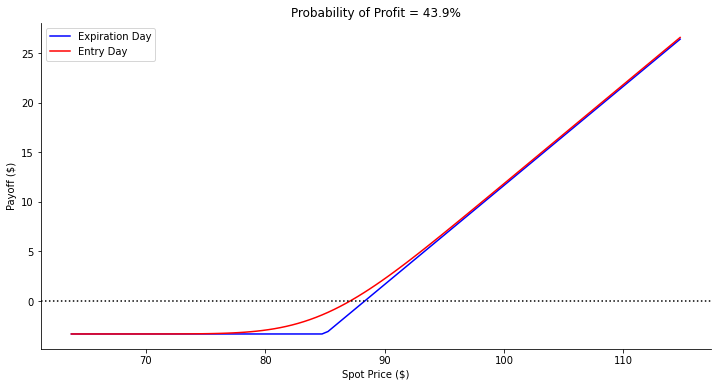

In [6]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
print('Option Premium = '+"${:.2f}".format(payoff.option_price[0]))
payoff.plot_payoff()

#### * Note that regardless of the strike/expiration date you choose, the probability of profit for longing an option is always less than 50%

##### b. Compare returns by holding the option vs. buy&hold the underlying

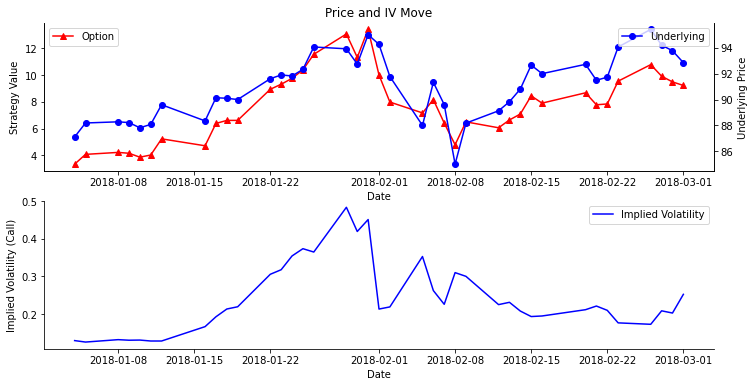

In [7]:
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)
bt1.plot_price_history()

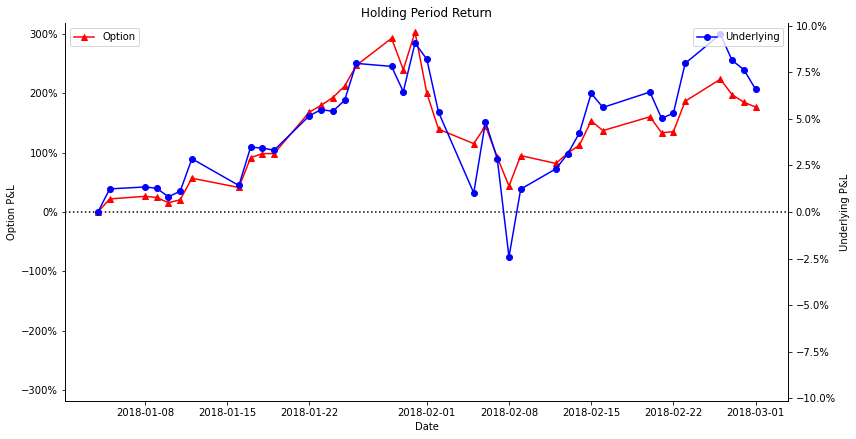

In [8]:
bt1.plot_option_pnl()

#### c. Strategy Summary

In [9]:
bt1.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2018-01-04,$333.33,2018-03-01,56,$922.46,$589.13,$10.52,176.7%,True


### III. Recurring Strategy Setup

#### a. Choose the backtesting period for the recurring startegy

In [22]:
Start_Date = datetime.datetime(2016, 1, 4)
End_Date = datetime.datetime(2018,8, 30)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### b. Set trading rules

#### Simplified (current):
* Enter: 43 days before expriation
* Exit: 21 days before expiration
* Strike prices = enter day underlying price - \\$5

#### Realistic (example):
* IV < 20%
* Expiration date < 60 & Expiration date > 45
* VIX < 20
* other technical signals.

In [23]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=24)
expiration_dates = pd.to_datetime(expiration_dates)

#### c. Run recursive analysis

In [25]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = [80]
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-5]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))

In [26]:
strike_price = np.array(strike_price)

In [27]:
win_rate

'70.97%'

In [28]:
strategy_performance.reset_index(drop=True, inplace=True)
strategy_performance

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2016-01-07,$0.00,2016-01-31,24,$0.00,$-0.00,$-0.00,-99.8%,False
1,2016-02-04,$302.01,2016-02-28,24,$237.14,$-64.87,$-2.70,-21.5%,False
2,2016-03-03,$617.55,2016-03-27,24,$796.71,$179.16,$7.47,29.0%,True
3,2016-04-07,$560.94,2016-05-01,24,$180.71,$-380.23,$-15.84,-67.8%,False
4,2016-05-05,$519.04,2016-05-29,24,$750.32,$231.28,$9.64,44.6%,True
5,2016-06-02,$524.34,2016-06-26,24,$326.72,$-197.62,$-8.23,-37.7%,False
6,2016-07-07,$667.11,2016-07-31,24,$1190.28,$523.17,$21.80,78.4%,True
7,2016-08-04,$577.75,2016-08-28,24,$641.61,$63.86,$2.66,11.1%,True
8,2016-09-08,$449.78,2016-10-02,24,$466.74,$16.96,$0.71,3.8%,True
9,2016-10-06,$536.01,2016-10-30,24,$734.87,$198.85,$8.29,37.1%,True


In [32]:
strategy_performance['Cost Basis']
avg_cost =strategy_performance['Cost Basis'].str.strip('$').astype(float).mean()
print('Avg Cost: ', "${:.2f}".format(avg_cost))

Avg Cost:  $540.62


In [33]:
strategy_performance['P&L']
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', "${:.2f}".format(pnl_sum))

Total Profit:  $4507.33
